# Spectrogram Image Analysis  and Reconstruction

## By Alejandro Gómez Orjuela and Melanie Giraldo C

## Introduction

#### In this project, you will explore the intersection of image and audio processingby converting an audio file into a visual spectrogram and applying image processing techniques to enhance or alter the spectrogram. After processing theimage,you will reconstruct the original audio from the modified spectrogram.This project will help you understand the relationship between sound and itsvisual representation, while applying your knowledge of both image processing(Module 1) and audio processing (Module 2).

## Objective

#### The primary objective of this project is to convert an audio file into a spectrogram, which is an image representation of sound, and then apply image processing techniques to enhance or modify the spectrogram. After making visual modifications, the goal is to reconstruct the modified audio from the spectrogram image. Finally, the project aims to compare the original and reconstructed audio to understand the impact of the visual modifications.

## 1.Import libraries

In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio, display
import soundfile as sf
from sklearn.metrics import mean_squared_error
import librosa
from IPython.display import Audio, display


## 2.Audio to Spectrogram Conversion

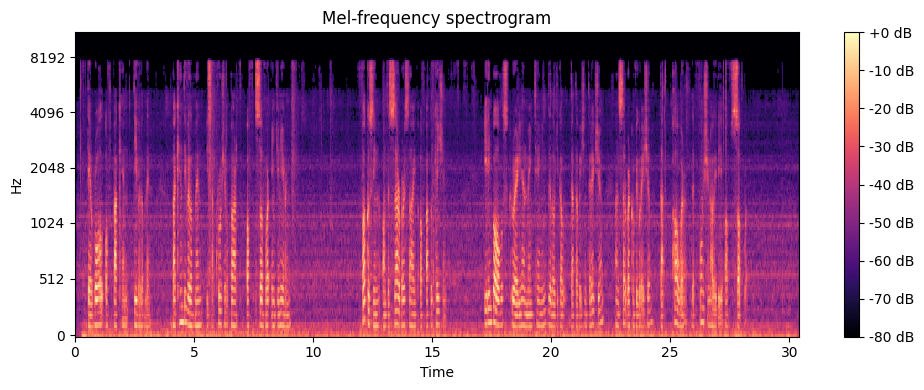

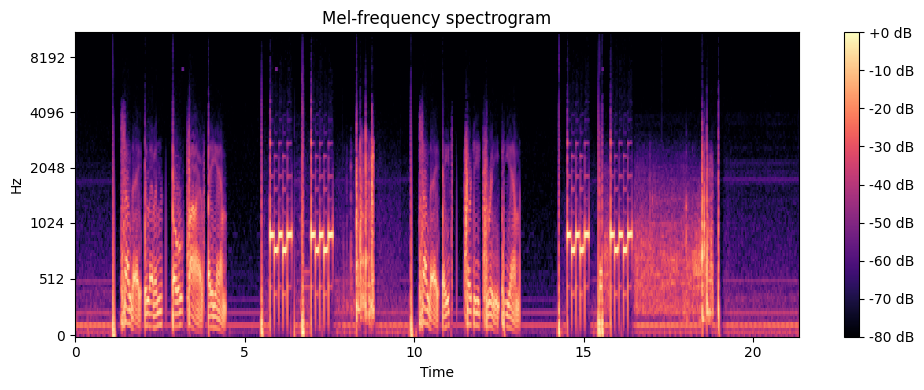

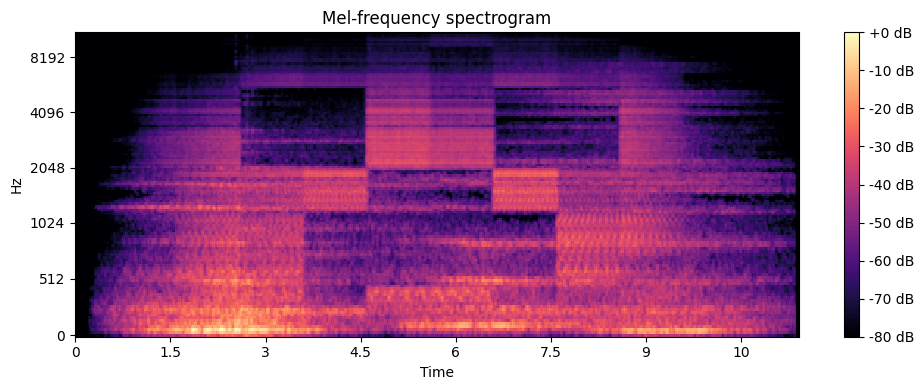

In [2]:

audio_files = ['data/audiovoice.mp3', 'data/voice.mp3', 'data/cave14.mp3']
spectrograms = []
def audio_to_spectrogram(audio_path):
    y, sr = librosa.load(audio_path)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    display(Audio(audio_path,rate=sr))
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()

    return S_dB
for audio_file in audio_files:
    spectrograms.append(audio_to_spectrogram(audio_file))

## 3.Image processing on the spectograma

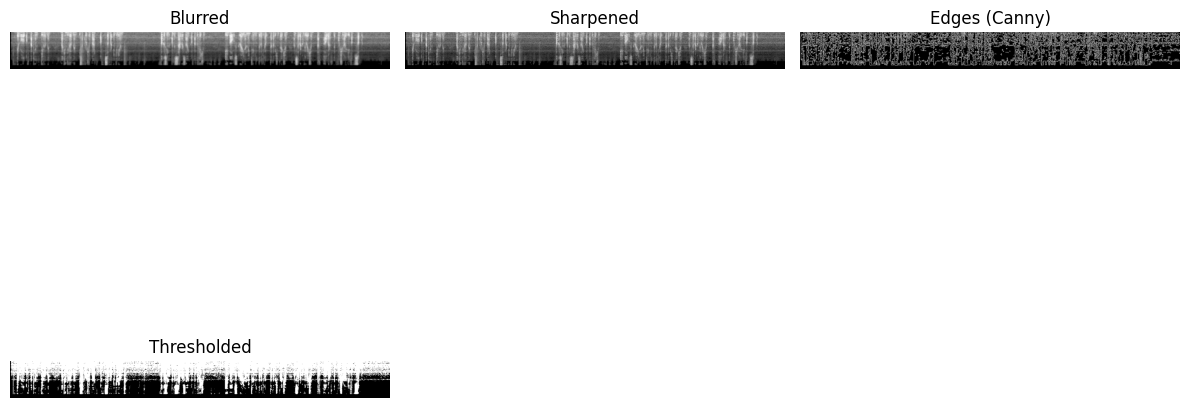

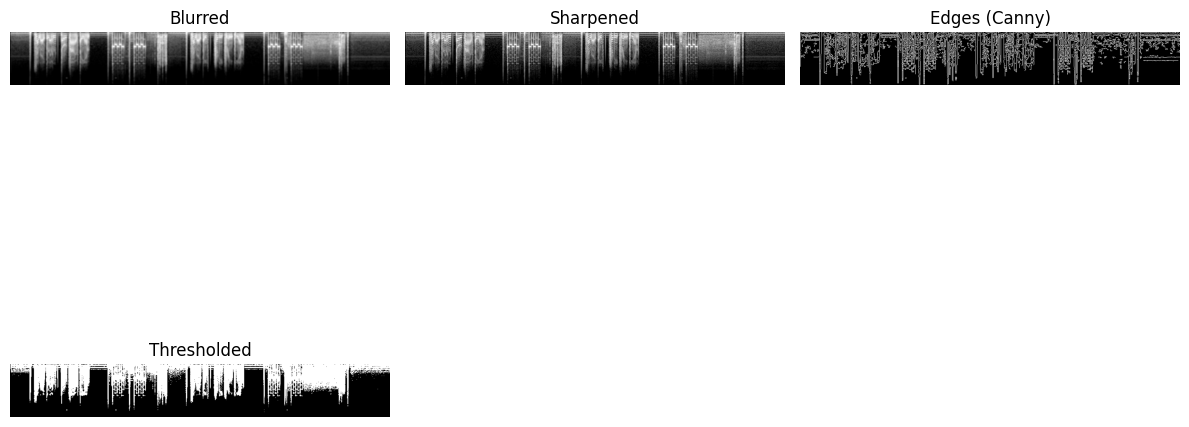

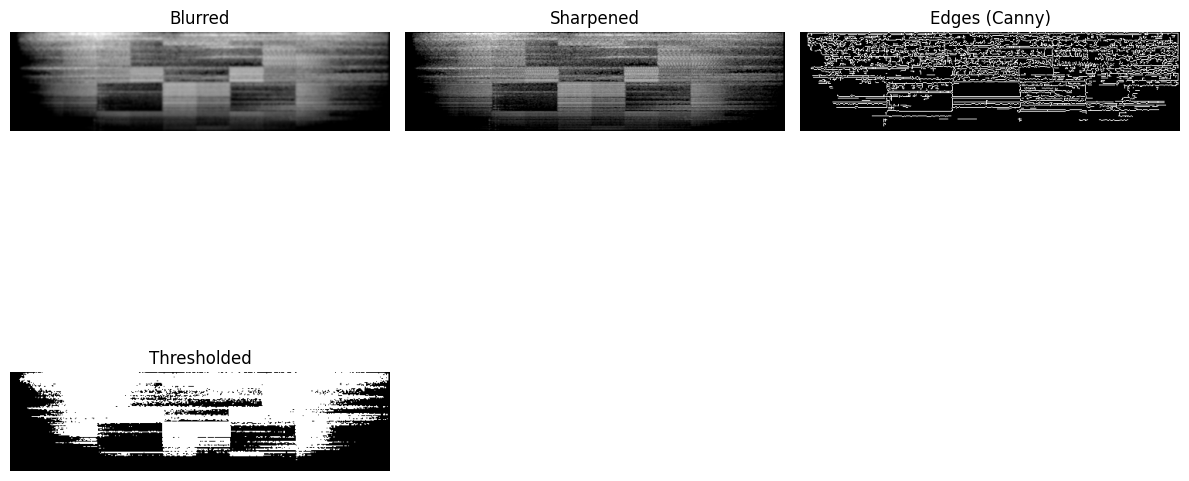

In [3]:
import cv2

processed_spectrograms = []


def process_spectrogram(spectrogram):
    spectrogram_img = np.uint8(255 * (spectrogram - np.min(spectrogram)) / (np.max(spectrogram) - np.min(spectrogram)))
    blurred = cv2.GaussianBlur(spectrogram_img, (5, 5), 0)
    sharpened = cv2.addWeighted(spectrogram_img, 1.5, blurred, -0.5, 0)
    edges = cv2.Canny(sharpened, 100, 200) 
    _, thresholded = cv2.threshold(sharpened, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    processed_spectrograms.append({
        'blurred': blurred,
        'sharpened': sharpened,
        'edges': edges,
        'thresholded': thresholded
    })

    plt.figure(figsize=(12, 8))
    plt.subplot(231), plt.imshow(blurred, cmap='gray'), plt.title('Blurred'), plt.axis('off')
    plt.subplot(232), plt.imshow(sharpened, cmap='gray'), plt.title('Sharpened'), plt.axis('off')
    plt.subplot(233), plt.imshow(edges, cmap='gray'), plt.title('Edges (Canny)'), plt.axis('off')
    plt.subplot(234), plt.imshow(thresholded, cmap='gray'), plt.title('Thresholded'), plt.axis('off')
    plt.tight_layout()
    plt.show()

    return sharpened

for spectrogram in spectrograms:
    process_spectrogram(spectrogram)

## 4.Reconstructing audios

In [4]:
reconstructed_audios = []

def reconstruct_audio_from_spectrogram(processed_spectrogram, sr=22050):
    S_inv = librosa.db_to_power(processed_spectrogram)
    y_inv = librosa.feature.inverse.mel_to_audio(S_inv, sr=sr)
    display(Audio(y_inv, rate=sr))
    reconstructed_audios.append(y_inv)
    
    return y_inv

for processed in processed_spectrograms:
    reconstruct_audio_from_spectrogram(processed['sharpened'], sr=22050)


## 5.Comparison

Audio 1 - Original Features:
Duration: 30.40 s, Dominant Frequency: 23.55 Hz, RMS: 0.0135
Audio 1 - Reconstructed Features:
Duration: 13.96 s, Dominant Frequency: 732.17 Hz, RMS: 2120436608.0000
Mean Squared Error between original and reconstructed audio 1: 37778366309360205824.000000


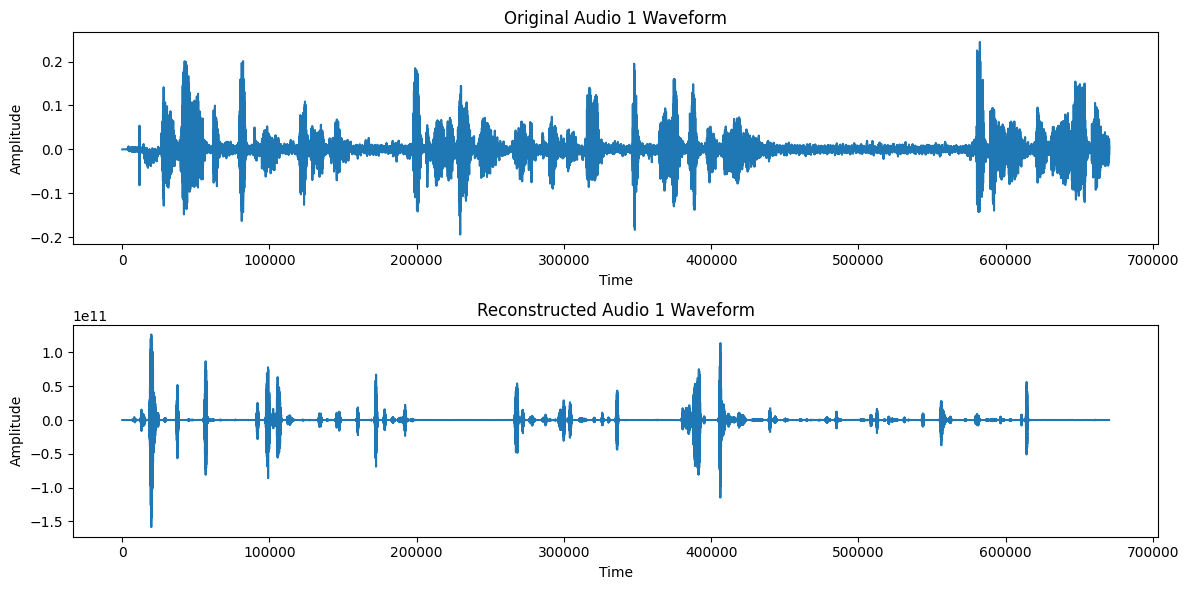

Audio 2 - Original Features:
Duration: 21.36 s, Dominant Frequency: 919.99 Hz, RMS: 0.0662
Audio 2 - Reconstructed Features:
Duration: 19.61 s, Dominant Frequency: 1011.05 Hz, RMS: 8476144640.0000
Mean Squared Error between original and reconstructed audio 2: 259249202376187314176.000000


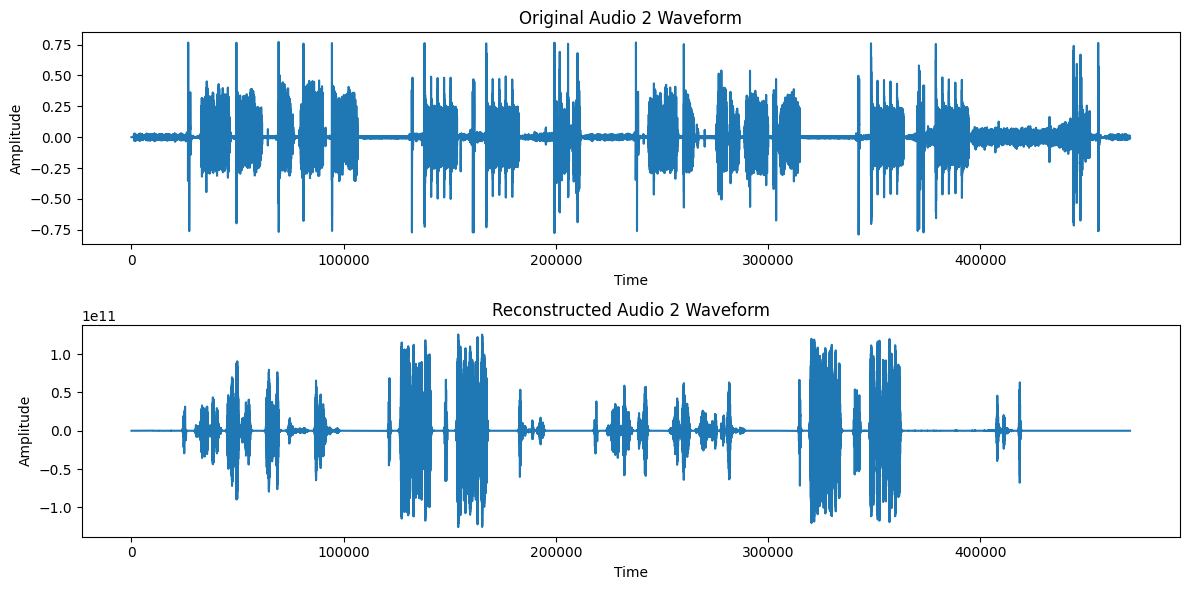

Audio 3 - Original Features:
Duration: 11.40 s, Dominant Frequency: 76.66 Hz, RMS: 0.0328
Audio 3 - Reconstructed Features:
Duration: 5.70 s, Dominant Frequency: 153.14 Hz, RMS: 2408881920.0000
Mean Squared Error between original and reconstructed audio 3: 55945513372219342848.000000


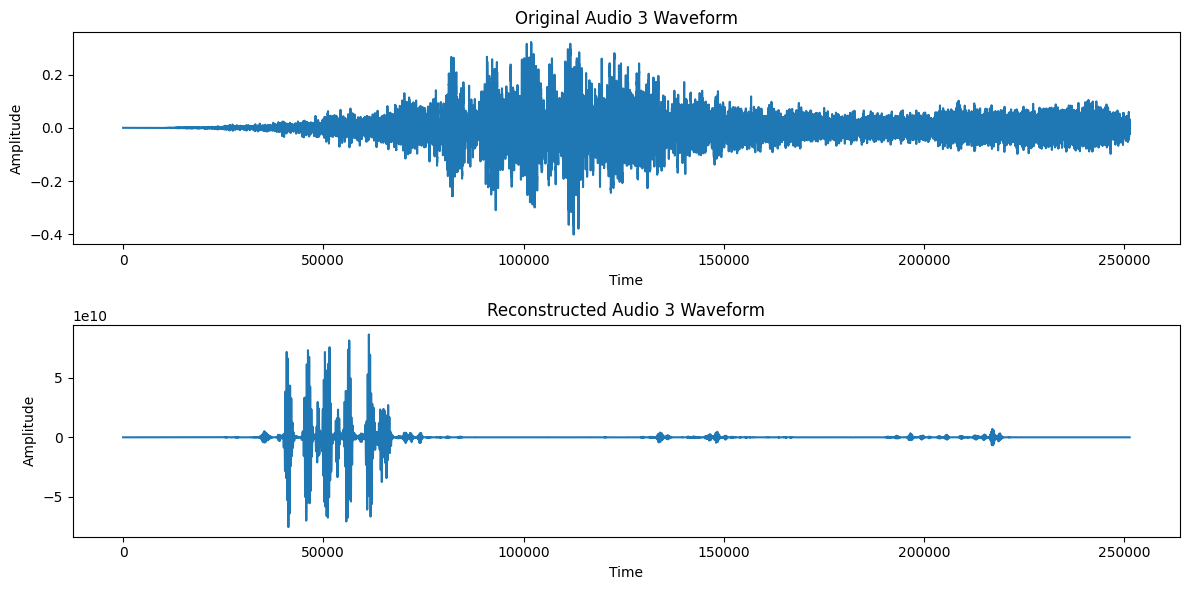

In [5]:
def load_audio(file_path):
    signal, sr = librosa.load(file_path, sr=None)  # Load with the original sampling rate
    return signal, sr

original_audios = [load_audio(audio_file) for audio_file in audio_files]

def extract_audio_features(signal, sr):
    duration = librosa.get_duration(y=signal, sr=sr)
    rms = librosa.feature.rms(y=signal)[0]
    fft = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(fft), 1/sr)
    idx = np.argmax(np.abs(fft))
    dominant_freq = abs(freqs[idx])
    return duration, rms, dominant_freq

def compare_and_plot(original_audio, reconstructed_audio, sr, i):

    duration_orig, rms_orig, dominant_freq_orig = extract_audio_features(original_audio, sr)
    duration_recon, rms_recon, dominant_freq_recon = extract_audio_features(reconstructed_audio, sr)
    print(f"Audio {i+1} - Original Features:\nDuration: {duration_orig:.2f} s, Dominant Frequency: {dominant_freq_orig:.2f} Hz, RMS: {np.mean(rms_orig):.4f}")
    print(f"Audio {i+1} - Reconstructed Features:\nDuration: {duration_recon:.2f} s, Dominant Frequency: {dominant_freq_recon:.2f} Hz, RMS: {np.mean(rms_recon):.4f}")
    min_length = min(len(original_audio), len(reconstructed_audio))
    mse = mean_squared_error(original_audio[:min_length], reconstructed_audio[:min_length])
    print(f"Mean Squared Error between original and reconstructed audio {i+1}: {mse:.6f}")


    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(original_audio[:min_length])
    plt.title(f'Original Audio {i+1} Waveform')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    plt.subplot(2, 1, 2)
    plt.plot(reconstructed_audio[:min_length])
    plt.title(f'Reconstructed Audio {i+1} Waveform')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()
for i, ((original_audio, sr), reconstructed_audio) in enumerate(zip(original_audios, reconstructed_audios)):
    compare_and_plot(original_audio, reconstructed_audio, sr, i)

## Conclusions

#### The comparison between the original and reconstructed audios reveals significant differences in terms of duration, dominant frequency, and RMS (Root Mean Square). The reconstructed audios are much shorter in duration, have substantially higher dominant frequencies, and exhibit drastically inflated RMS values, suggesting a major alteration in amplitude and sound quality. The extremely high mean squared error values indicate that the reconstructed audios deviate heavily from the original ones, highlighting a potential issue in the reconstruction process that significantly distorts the sound.